In [71]:
from Module.MySQL_connector import MySQLConnector
import pandas as pd
import os

In [72]:
# import data from MySQL
sql_connector = MySQLConnector('192.168.31.130', 'bigred', 'bigred', 32010)
sql_connector.connectDB('g3_db')
# print(sql_connector.execute_query('show tables;'))
sql_connector.execute_query('show tables;')
main_table = pd.DataFrame(sql_connector.execute_query("select * from main_aa"))
genres_onehot = pd.DataFrame(sql_connector.execute_query("select * from genres_onehot_aa"))
features_onehot = pd.DataFrame(sql_connector.execute_query("select * from features_onehot_aa"))
tags_onehot = pd.DataFrame(sql_connector.execute_query("select * from tags_onehot_aa"))
id_publisher_aa = pd.DataFrame(sql_connector.execute_query("select * from id_publishers_aa"))
publishers_info_aa = pd.DataFrame(sql_connector.execute_query("select * from publishers_info_aa;"))

Connected to g3_db on 192.168.31.130:32010


In [73]:
copiesold = pd.DataFrame(sql_connector.execute_query("select * from first30days_sales_2A"))
copiesold = copiesold.drop(columns=['timeStamp','releaseDate','days_since_release'])

In [74]:
# 合併時指定 suffixes 參數來處理重複列
merged_table = pd.merge(main_table, genres_onehot, on='steamId', suffixes=('', '_genres'))
merged_table = pd.merge(merged_table, tags_onehot, on='steamId', suffixes=('', '_tags'))
# 再次合併時，處理更多的重複列
merged_table = pd.merge(merged_table, features_onehot, on='steamId', suffixes=('', '_features'))


In [75]:
# 找到所有帶有 '_tags' 或 '_features' 後綴的列名
replicated_columns = [col for col in merged_table.columns if '_tags' in col or '_features' in col]

# 刪除這些列
merged_table.drop(columns=replicated_columns, inplace=True)

In [76]:
cs_pub = pd.merge(copiesold,id_publisher_aa,on="steamId")
# cs_pub_info = pd.merge(cs_pub, publishers_info_aa, on="steamId")
cs_pub_info = pd.merge(cs_pub, publishers_info_aa, left_on='publisher', right_on="name")


In [77]:
cs_pub_info=cs_pub_info.dropna()

In [78]:

full_table = pd.merge(cs_pub_info, merged_table, on="steamId",suffixes=('', '_pub'))
# full_table = pd.merge(merged_table, copiesold, on="steamId")


In [79]:
columns_to_drop = ['steamId','totalRevenue_pub','publisher','name_pub','name','reviews','reviewsSteam','followers','avgPlaytime','reviewScore','releaseDate','firstReleaseDate','copiesSold','revenue','totalRevenue','players','owners','wishlists']
full_table=full_table.drop(columns=columns_to_drop)

In [80]:
full_table = full_table.dropna()
full_table

,sales,averageRevenue,medianRevenue,publishedGames,price,earlyAccess,Action,Adventure,Casual,Early Access,...,Steam Cloud,Steam Leaderboards,Steam Trading Cards,Steam Turn Notifications,Steam Workshop,SteamVR Collectibles,Tracked Controller Support,VR Only,VR Supported,Valve Anti-Cheat enabled
0,0.000000e+00,3.097318e+06,555213.0,127,5.99,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5.691300e+04,3.097318e+06,555213.0,127,5.99,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.796316e+05,2.301824e+07,21042950.0,8,19.99,0,1,1,0,0,...,1,1,1,0,0,0,0,0,0,0
3,1.099500e+06,1.259276e+07,2115005.0,11,39.99,0,0,0,0,0,...,1,0,1,0,1,0,0,0,0,0
4,5.393900e+04,6.568174e+06,2458665.0,35,19.99,0,1,1,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1239,1.050977e+06,8.568731e+06,5725398.0,7,7.99,0,1,1,0,0,...,1,0,0,0,0,0,0,0,0,0
1240,4.581000e+03,1.565075e+06,425891.5,50,59.99,0,1,1,0,0,...,1,0,1,0,0,0,0,0,0,0
1241,9.695800e+04,3.749863e+06,708029.0,49,19.99,0,1,0,0,0,...,1,0,1,0,0,0,0,0,0,0
1242,2.590000e+03,1.565075e+06,425891.5,50,39.99,0,1,1,0,0,...,1,0,1,0,0,0,0,0,0,0


In [16]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# 初始化 MinMaxScaler
scaler = MinMaxScaler()
full_table['medianRevenue'] = np.log1p(full_table['medianRevenue'])
full_table['averageRevenue'] = np.log1p(full_table['averageRevenue'])

# 選擇要正規化的欄位
columns_to_scale = ["price", "publishedGames","medianRevenue", "averageRevenue"]
# "medianRevenue", "averageRevenue"
# 對指定欄位進行 Min-Max 轉換
full_table[columns_to_scale] = scaler.fit_transform(full_table[columns_to_scale])
full_table['sales'] = np.log1p(full_table['sales'])

# full_table 中的這些欄位現在已經進行 Min-Max 正規化
print(full_table.head())


       sales  averageRevenue  medianRevenue  publishedGames     price  \
0   0.000000        0.298600       0.313861        0.696133  0.074884   
1  10.949297        0.298600       0.313861        0.696133  0.074884   
2  12.098669        0.627299       0.729617        0.038674  0.249906   
3  13.910367        0.528454       0.466836        0.055249  0.499937   
4  10.895628        0.421788       0.484056        0.187845  0.249906   

   earlyAccess  Action  Adventure  Casual  Early Access  ...  Steam Cloud  \
0        False       1          0       0             0  ...            0   
1        False       1          0       0             0  ...            0   
2        False       1          1       0             0  ...            1   
3        False       0          0       0             0  ...            1   
4        False       1          1       0             0  ...            0   

   Steam Leaderboards  Steam Trading Cards  Steam Turn Notifications  \
0                   0     

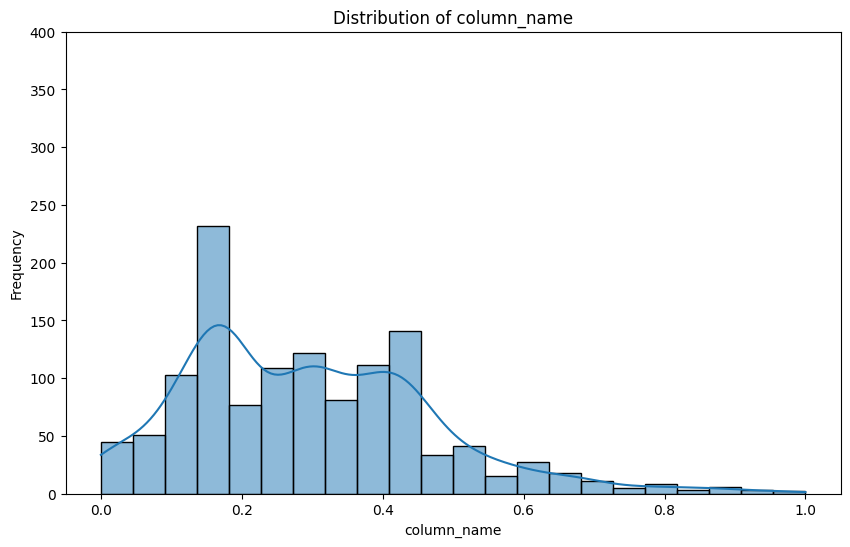

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# 假設你要繪製 df['column_name'] 的分布
plt.figure(figsize=(10, 6))
sns.histplot(full_table["averageRevenue"], kde=True)  # kde=True 可以添加密度估計曲線
plt.title('Distribution of column_name')
plt.xlabel('column_name')
plt.ylabel('Frequency')
plt.ylim(0, 400)
plt.show()

In [18]:
corr_df = full_table[["averageRevenue","medianRevenue","publishedGames","price","sales"]]

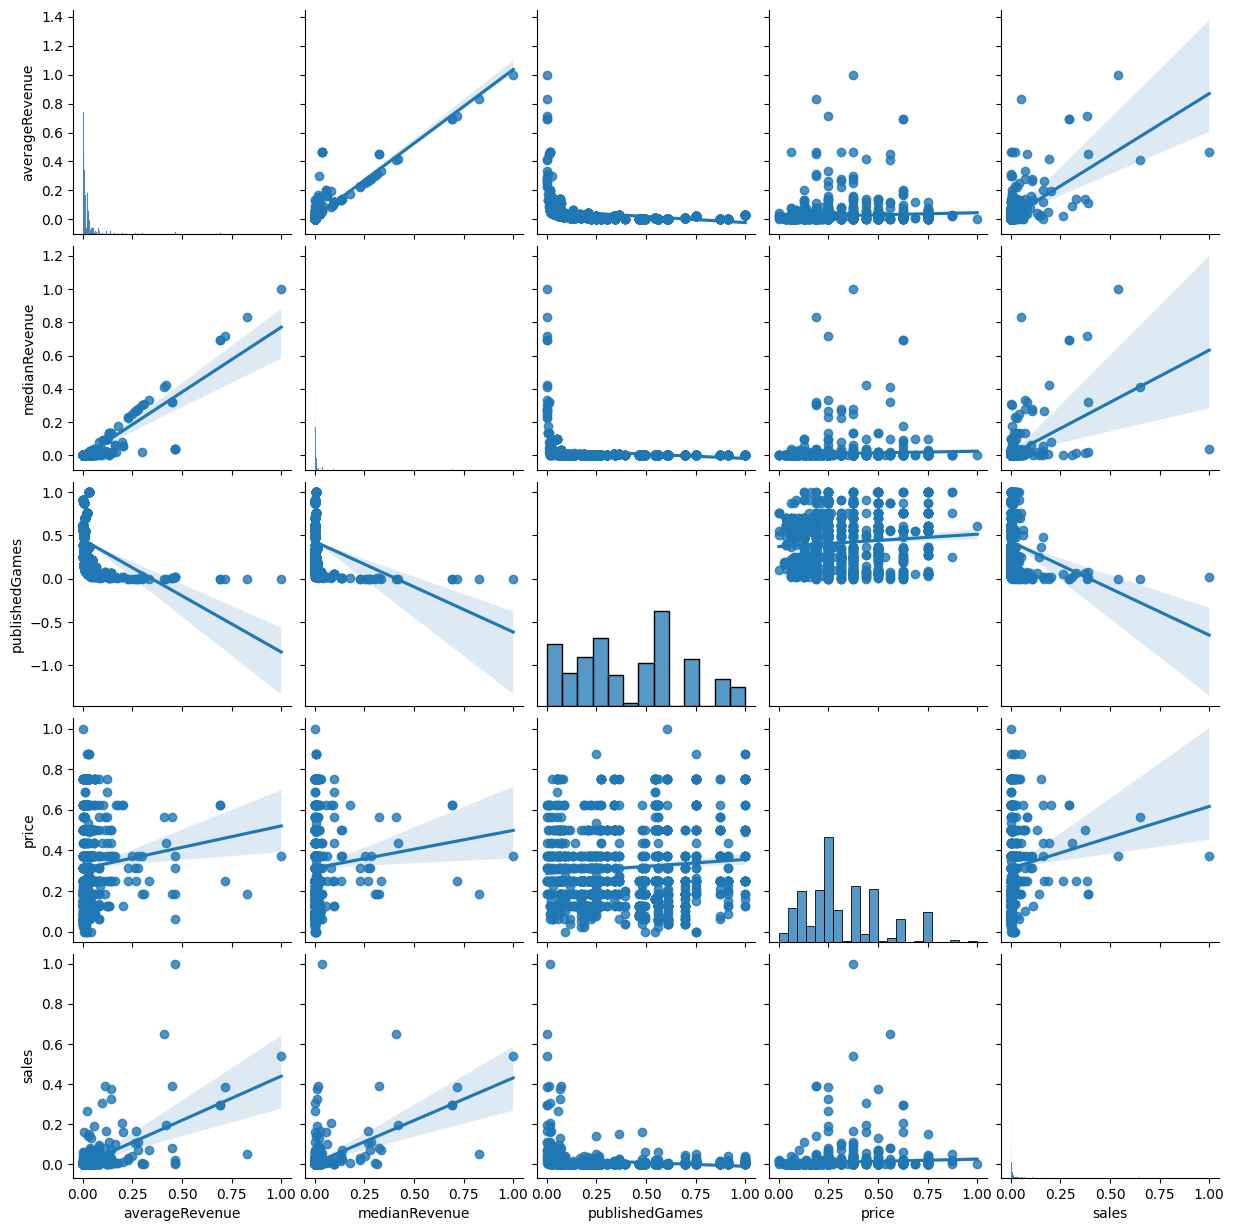

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# 假設 corr_df 是你的數據框
sns.pairplot(corr_df, kind="reg")  # kind="reg" 會添加回歸線

# 顯示圖表
plt.show()

<Axes: >

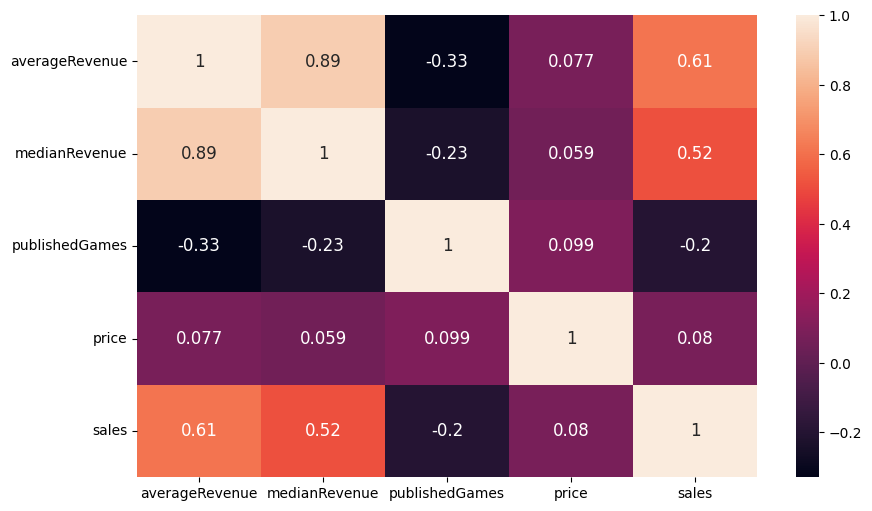

In [20]:
corrmat = corr_df.corr()
fig, ax = plt.subplots(figsize = (10, 6))
sns.heatmap(corrmat, annot = True, annot_kws={'size': 12})

In [18]:
X_full = full_table.drop(columns="sales").values
Y_full = full_table['sales'].values

In [19]:
X_full.shape

(1244, 465)

In [68]:
from sklearn.decomposition import PCA

# 1. 應用 PCA
pca = PCA(n_components=0.95)  # 保留 95% 的變異性
X_pca = pca.fit_transform(X_full)

In [69]:
from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 25)
# X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_pca, Y_full, test_size = 0.3, random_state = 25)
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full, Y_full, test_size = 0.3, random_state = 25)

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.linear_model import LinearRegression,Lasso
from sklearn.metrics import r2_score

In [26]:
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error

def poly_ridge(X_train, X_test, y_train, y_test):
    # 使用 Ridge 進行正則化回歸
    degree = 2  # 減少多項式次數
    ridge_poly = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=0.01))

    # 訓練模型
    ridge_poly.fit(X_train, y_train)

    # 預測
    y_pred_train = ridge_poly.predict(X_train)
    y_pred_test = ridge_poly.predict(X_test)

    # 計算 R² 分數
    r2_score_ridge_train = r2_score(y_train, y_pred_train)
    r2_score_ridge_test = r2_score(y_test, y_pred_test)

    # 計算 RMSE
    rmse_ridge_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_ridge_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

    # 打印結果
    print("R² score (train):", r2_score_ridge_train)
    print("R² score (test):", r2_score_ridge_test)
    print("Train RMSE:", rmse_ridge_train)
    print("Test RMSE:", rmse_ridge_test)

# poly_ridge(X_train, X_test, y_train, y_test)
poly_ridge(X_train_full, X_test_full, y_train_full, y_test_full)


R² score (train): 0.9862679134410135
R² score (test): 0.027994918630881216
Train RMSE: 0.2726519491043148
Test RMSE: 2.280435347959337


In [70]:
# xgboost regression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# 使用 XGBRegressor 而不是 XGBClassifier
model_xg = XGBRegressor(n_estimators=1100, learning_rate=0.05, max_depth=6)
model_xg.fit(X_train_full, y_train_full)

# 預測測試集
y_test_pred_xg = model_xg.predict(X_test_full)
y_train_pred_xg = model_xg.predict(X_train_full)
# 評估模型表現
r2_train = r2_score(y_train_full, y_train_pred_xg)
r2_test = r2_score(y_test_full, y_test_pred_xg)
mse_train = mean_squared_error(y_train_full, y_train_pred_xg)
mse_test = mean_squared_error(y_test_full, y_test_pred_xg)

print(f"train Mean Squared Error: {mse_train}")
print(f"train R² Score: {r2_train}")
print(f"validation Mean Squared Error: {mse_test}")
print(f"validation R² Score: {r2_test}")


train Mean Squared Error: 0.07433489129440737
train R² Score: 0.9862686881766644
validation Mean Squared Error: 3.0842870845321535
validation R² Score: 0.4235152778727117


[0]	validation_0-rmse:2.26084	validation_1-rmse:2.27095
[1]	validation_0-rmse:2.19925	validation_1-rmse:2.22970
[2]	validation_0-rmse:2.14232	validation_1-rmse:2.19384
[3]	validation_0-rmse:2.09020	validation_1-rmse:2.16037
[4]	validation_0-rmse:2.04005	validation_1-rmse:2.13066
[5]	validation_0-rmse:1.99252	validation_1-rmse:2.10313
[6]	validation_0-rmse:1.94819	validation_1-rmse:2.07923
[7]	validation_0-rmse:1.90639	validation_1-rmse:2.05515
[8]	validation_0-rmse:1.86700	validation_1-rmse:2.03520
[9]	validation_0-rmse:1.82873	validation_1-rmse:2.01473
[10]	validation_0-rmse:1.78997	validation_1-rmse:1.99333
[11]	validation_0-rmse:1.75618	validation_1-rmse:1.97891
[12]	validation_0-rmse:1.72285	validation_1-rmse:1.96194
[13]	validation_0-rmse:1.69209	validation_1-rmse:1.94770
[14]	validation_0-rmse:1.66304	validation_1-rmse:1.93762
[15]	validation_0-rmse:1.63489	validation_1-rmse:1.92432
[16]	validation_0-rmse:1.60397	validation_1-rmse:1.90754
[17]	validation_0-rmse:1.57691	validation

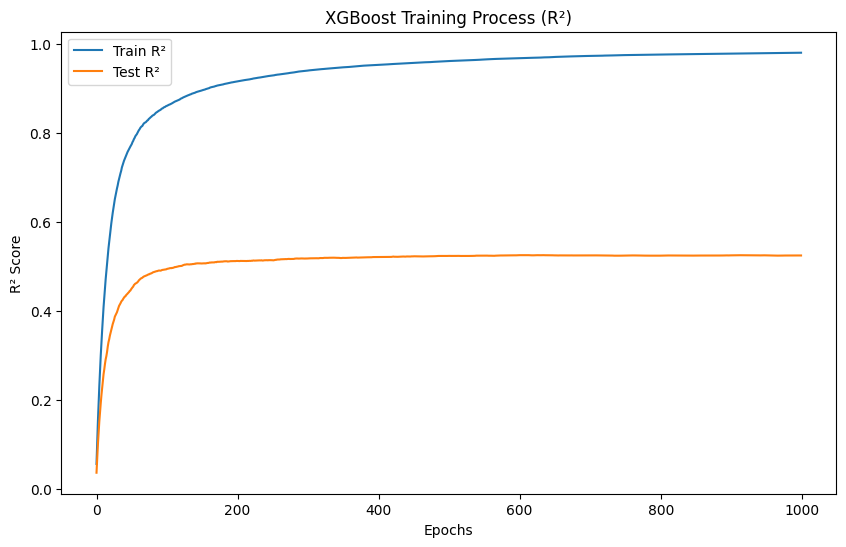

In [48]:
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
import numpy as np

# 初始化用於儲存每輪的 R² 分數
train_r2_history = []
test_r2_history = []

# 設置模型
model_xg = XGBRegressor(n_estimators=1000, learning_rate=0.05)

# 訓練過程中進行監控
eval_set = [(X_train_full, y_train_full), (X_test_full, y_test_full)]
model_xg.fit(X_train_full, y_train_full, 
             eval_set=eval_set, 
             verbose=True)

# 使用 evals_result() 來監控訓練過程
results = model_xg.evals_result()

# 逐步計算每個 epoch 的 R²
for i in range(len(results['validation_0']['rmse'])):
    # 使用 iteration_range 參數指定使用的樹的範圍
    y_train_pred = model_xg.predict(X_train_full, iteration_range=(0, i+1))
    y_test_pred = model_xg.predict(X_test_full, iteration_range=(0, i+1))

    # 計算 R² 分數
    train_r2 = r2_score(y_train_full, y_train_pred)
    test_r2 = r2_score(y_test_full, y_test_pred)

    # 保存 R² 分數
    train_r2_history.append(train_r2)
    test_r2_history.append(test_r2)

# 繪製 R² 分數隨訓練輪數的變化圖
epochs = len(train_r2_history)
x_axis = range(0, epochs)

plt.figure(figsize=(10, 6))
plt.plot(x_axis, train_r2_history, label='Train R²')
plt.plot(x_axis, test_r2_history, label='Test R²')
plt.legend()
plt.ylabel('R² Score')
plt.xlabel('Epochs')
plt.title('XGBoost Training Process (R²)')
plt.show()


In [47]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.98)
X_pca = pca.fit_transform(X_full)
# X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_pca, Y_full, test_size = 0.3, random_state = 25)
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full, Y_full, test_size = 0.3, random_state = 25)

In [48]:
poly_ridge(X_train_full, X_test_full, y_train_full, y_test_full)

R² score (train): 0.3632649166130357
R² score (test): 0.27234331907934495
Train RMSE: 1.8566059175820513
Test RMSE: 1.9730893712291313
